In [1]:
#import useful libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import pickle
import configuration
import general_statistics as stats
import figures as figs
import matplotlib.cm as cm
from matplotlib import colors
from scipy import signal
from scipy import stats as sstats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import scipy
cmap = cm.jet
import math
from sklearn.datasets import load_iris
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.cross_decomposition import CCA
from sklearn.model_selection import cross_val_score
import random
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from matplotlib.patches import Rectangle

import warnings
warnings.filterwarnings("ignore")
from analysis_functions import *


In [2]:
decoding_v = 1            ## decoding version, normaly equal to one
motion_correction_v = 20  ### 100 means everything was aligned, 200 means it was also equalized, 20 is for day wise
alignment_v = 3           ## alignment version, version 3 is for day wise
equalization_v = 0        ## equalization version
source_extraction_v = 1   ## source extraction version
component_evaluation_v = 1 ## component evaluation version
binary = False

# here we will do analysis with no registration
# registration_v = 2        ## registration version
sf = 10                   ## sampling frequency of the original signal 
re_sf= 1                 ## value of resampling
period = int(5 * sf / re_sf)
period_resting = period *50
N_SHUFFLINGS = 50
colorcodes = ['Greys','PuBu', 'YlOrRd','Reds','Blues','Oranges','Greens']
output_directory = '/home/melisamc/Documentos/neural_analysis/data/exploratory_time/'


In [27]:
mouse = 401714### mouse number id
metric_use = 'euclidean'

for session_now in range(1,3):

    print('SESSION ====', session_now)

    file_directory = os.environ['PROJECT_DIR'] + 'neural_analysis/data/calcium_activity_day_wise/'
    timeline_file_dir = os.environ['PROJECT_DIR'] + 'neural_analysis/data/timeline/'
    behaviour_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/ethogram/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
    behaviour_dir_parameters = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/ethogram_parameters/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
    tracking_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/center_of_mass/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
    objects_dir= os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/object_positions/'

    objects_position_file = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/occupied_corners/' + 'mouse_'+f'{mouse}'+'_session_'+f'{session_now}'+'.npy'
    occupied_corners = np.load(objects_position_file)
    task,colapse_behaviour,object_fixed,fixed,labels,colornames = mouse_properties(mouse = mouse, session_now = session_now)
    timeline_1, behaviour_list_trial,trial_list,corners_list_trial, speed_list_trial = load_behaviour_trial(mouse, session_now,decoding_v, motion_correction_v, alignment_v, equalization_v,source_extraction_v,component_evaluation_v, re_sf,file_directory, timeline_file_dir, behaviour_dir, behaviour_dir_parameters, tracking_dir, objects_dir)

    create_task_behaviour_trial(behaviour_list_trial,colapse_behaviour,object_fixed,timeline_1,trial_list)    
    navigation_list_trial, exploration_list_trial = create_corners_occupation(behaviour_list_trial, corners_list_trial, speed_list_trial,trial_list)   
    exploratory_time = np.full([4, 20], np.nan)
    #exploratory_time = np.empty((4,20))
    
    for i in range(len(navigation_list_trial)):
        values = np.unique(navigation_list_trial[i])
        values_ = values[np.where(values>0)]
        if len(values_)>=2:
            exploratory_time[0,i]=len(np.where(navigation_list_trial[i]==values_[0])[0])/len(navigation_list_trial[i])
            exploratory_time[1,i]=len(np.where(navigation_list_trial[i]==values_[1])[0])/len(navigation_list_trial[i])
            exploratory_time[2,i]=len(np.where(behaviour_list_trial[i]==3)[0])/len(navigation_list_trial[i])
            exploratory_time[3,i]=len(np.where(behaviour_list_trial[i]==4)[0])/len(navigation_list_trial[i])

    time_file = output_directory + 'exploratory_time_' + f'{mouse}' +'_session_'+ f'{session_now}' +'.npy'
    np.save(time_file,exploratory_time)  
 

SESSION ==== 1
LOADING...
SESSION ==== 2
LOADING...


### Pool all together

In [3]:
mouse_vector = [56165, 32363, 32364, 32365, 411857, 411857, 401714]
conditions_vector = ['RANDOM', 'OVERLAPPING','STABLE']
sessions_random = [0,1,0,2,2,6,2] # total = 6
sessions_overlapping = [1,2,1,0,3,5,0] # total = 6
fixed_corner = [3,4,1,0,2,4,0]
sessions_stable = [2,0,0,0,1,4,1] # total = 5 (4 and 1/2)

random = []
overlapping = []
stable = []

for i in range(len(mouse_vector)):
    mouse = mouse_vector[i]
    #### check session_random
    session = sessions_random[i]
    if session:
        file_name = output_directory + 'exploratory_time_' + f'{mouse}' +'_session_' + f'{session}'+ '.npy'
        if os.path.isfile(file_name):
            di = np.load(file_name)
            random.append(di)
    session = sessions_overlapping[i]
    if session:
        file_name = output_directory + 'exploratory_time_' + f'{mouse}' +'_session_' + f'{session}'+ '.npy'
        if os.path.isfile(file_name):
            di = np.load(file_name)
            overlapping.append(di)
    session = sessions_stable[i]
    if session:
        print(mouse)
        file_name = output_directory + 'exploratory_time_' + f'{mouse}' +'_session_' + f'{session}'+ '.npy'
        if os.path.isfile(file_name):
            di = np.load(file_name)
            stable.append(di)

56165
411857
411857
401714


In [4]:
# overlapping_list = []
# random_list = []
# stable_list = []

# for j in range(4):

#     overlapping_matrix = np.zeros((len(overlapping),20))
#     random_matrix = np.zeros((len(random),20))
#     stable_matrix = np.zeros((len(stable),20))
#     for i in range(len(overlapping)):
#         overlapping_matrix[i,:] = np.cumsum(overlapping[i][j,:])/np.sum(overlapping[i][j,:])
#     for i in range(len(random)):
#         random_matrix[i,:] = np.cumsum(random[i][j,:])/np.sum(random[i][j,:])
#     for i in range(len(stable)):
#         stable_matrix[i,:] = np.cumsum(stable[i][j,:])/np.sum(stable[i][j,:])

#     overlapping_list.append(overlapping_matrix)
#     stable_list.append(stable_matrix)
#     random_list.append(random_matrix)
# data_path = os.environ['PROJECT_DIR'] +'neural_analysis/figures/mean_representational_distance/lda_3/'
# file_name = 'cumulative_exp_time_overlapping.npy'
# np.save(data_path + file_name, overlapping_list)
# file_name = 'cumulative_exp_time_random.npy'
# np.save(data_path + file_name, random_list)
# file_name = 'cumulative_exp_time_stable.npy'
# np.save(data_path + file_name, stable_list)

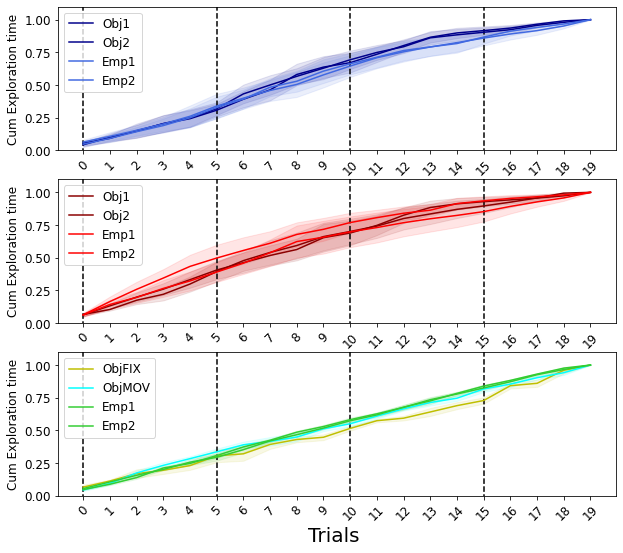

In [5]:
figure_path = os.environ['PROJECT_DIR'] +'neural_analysis/figures/mean_representational_distance/lda_3/'

overlapping_list = []
random_list = []
stable_list = []
for i in range(len(overlapping)):
    overlapping_matrix = np.zeros((4,20))
    for j in range(4):
        overlapping_matrix[j,:] = np.nancumsum(overlapping[i][j,:])/np.nansum(overlapping[i][j,:])
    overlapping_list.append(overlapping_matrix)

for i in range(len(random)):
    random_matrix = np.zeros((4,20))
    for j in range(4):
        random_matrix[j,:] = np.nancumsum(random[i][j,:])/np.nansum(random[i][j,:])
    random_list.append(random_matrix)

for i in range(len(stable)):
    stable_matrix = np.zeros((4,20))
    for j in range(4):
        stable_matrix[j,:] = np.nancumsum(stable[i][j,:])/np.nansum(stable[i][j,:])
    stable_list.append(stable_matrix)
    
random_mean_occ = np.nanmean(random_list, axis = 0)
random_sem_occ =  np.nanstd(random_list,axis = 0)/np.sqrt(len(random_list))

stable_mean_occ = np.nanmean(stable_list, axis = 0)
stable_sem_occ =  np.nanstd(stable_list,axis = 0)/np.sqrt(len(stable_list))

overlapping_mean_occ = np.nanmean(overlapping_list, axis = 0)
overlapping_sem_occ =  np.nanstd(overlapping_list,axis = 0)/np.sqrt(len(overlapping_list))


figure, axes = plt.subplots(3,1)
 
titles = ['RANDOM','STABLE','OVERLAPPING']

time = np.arange(0,20)
axes[0].plot(time,random_mean_occ[2,time],'darkblue')
axes[1].plot(time,stable_mean_occ[2,time],'darkred')
axes[2].plot(time,overlapping_mean_occ[2,time],'y')
axes[0].fill_between(time,random_mean_occ[2,time]-random_sem_occ[2,time],random_mean_occ[2,time]+random_sem_occ[2,time],alpha = 0.1, edgecolor = 'darkblue', facecolor = 'darkblue')
axes[1].fill_between(time,stable_mean_occ[2,time]-stable_sem_occ[2,time],stable_mean_occ[2,time]+stable_sem_occ[2,time],alpha = 0.1, edgecolor = 'darkred', facecolor = 'darkred')
axes[2].fill_between(time,overlapping_mean_occ[2,time]-overlapping_sem_occ[2,time],overlapping_mean_occ[2,time]+overlapping_sem_occ[2,time],alpha = 0.1, edgecolor = 'y', facecolor = 'y')


axes[0].plot(time,random_mean_occ[3,time],'darkblue')
axes[1].plot(time,stable_mean_occ[3,time],'darkred')
axes[2].plot(time,overlapping_mean_occ[3,time],'cyan')
axes[0].fill_between(time,random_mean_occ[3,time]-random_sem_occ[3,time],random_mean_occ[3,time]+random_sem_occ[3,time],alpha = 0.1, edgecolor = 'darkblue', facecolor = 'darkblue')
axes[1].fill_between(time,stable_mean_occ[3,time]-stable_sem_occ[3,time],stable_mean_occ[3,time]+stable_sem_occ[3,time],alpha = 0.1, edgecolor = 'darkred', facecolor = 'darkred')
axes[2].fill_between(time,overlapping_mean_occ[3,time]-overlapping_sem_occ[3,time],overlapping_mean_occ[3,time]+overlapping_sem_occ[3,time],alpha = 0.1, edgecolor = 'cyan', facecolor = 'cyan')
  
    
axes[0].plot(time,random_mean_occ[0,time],'royalblue')
axes[1].plot(time,stable_mean_occ[0,time],'red')
axes[2].plot(time,overlapping_mean_occ[0,time],'limegreen')
axes[0].fill_between(time,random_mean_occ[0,time]-random_sem_occ[0,time],random_mean_occ[0,time]+random_sem_occ[0,time],alpha = 0.1, edgecolor = 'royalblue', facecolor = 'royalblue')
axes[1].fill_between(time,stable_mean_occ[0,time]-stable_sem_occ[0,time],stable_mean_occ[0,time]+stable_sem_occ[0,time],alpha = 0.1, edgecolor = 'red', facecolor = 'red')
axes[2].fill_between(time,overlapping_mean_occ[0,time]-overlapping_sem_occ[0,time],overlapping_mean_occ[0,time]+overlapping_sem_occ[0,time],alpha = 0.1, edgecolor = 'limegreen', facecolor = 'limegreen')
  
axes[0].plot(time,random_mean_occ[1,time],'royalblue')
axes[1].plot(time,stable_mean_occ[1,time],'red')
axes[2].plot(time,overlapping_mean_occ[1,time],'limegreen')
axes[0].fill_between(time,random_mean_occ[1,time]-random_sem_occ[1,time],random_mean_occ[1,time]+random_sem_occ[1,time],alpha = 0.1, edgecolor = 'royalblue', facecolor = 'royalblue')
axes[1].fill_between(time,stable_mean_occ[1,time]-stable_sem_occ[1,time],stable_mean_occ[1,time]+stable_sem_occ[1,time],alpha = 0.1, edgecolor = 'red', facecolor = 'red')
axes[2].fill_between(time,overlapping_mean_occ[1,time]-overlapping_sem_occ[1,time],overlapping_mean_occ[1,time]+overlapping_sem_occ[1,time],alpha = 0.1, edgecolor = 'limegreen', facecolor = 'limegreen')

    
for j in range(3):
    axes[j].set_ylim([0,1.1])
    axes[j].set_ylabel('Cum Exploration time',fontsize = 12)
    axes[j].tick_params(axis='x', labelsize=12)
    axes[j].set_xticks(np.arange(0,21))

    axes[j].tick_params(axis='y', labelsize=12)  
    for tick in axes[j].get_xticklabels():
        tick.set_rotation(45)
    #axes[j].hlines(0,0,20,color = 'k')  
    if j < 2:
        axes[j].legend(['Obj1','Obj2','Emp1','Emp2'], fontsize = 12)
    #axes[j].set_title(titles[j],fontsize = 20)
    axes[j].vlines([0,5,10,15], -1, 3, colors='k', linestyles='dashed')

axes[2].set_xlabel('Trials ',fontsize = 20)
axes[2].legend(['ObjFIX','ObjMOV','Emp1','Emp2'], fontsize = 12)

figure.set_size_inches([10,9])
figure.patch.set_facecolor('white')
figure.savefig(figure_path + 'cum_exploration_time_evolution.png')

In [6]:
# random = random_list
# overlapping = overlapping_list
# stable = stable_list

# exp_time_trial_random = []
# exp_time_day_random = []

# for j in range(4):
#     exp_mat_trial = np.zeros((len(random)*4,5))
#     exp_mat_day = np.zeros((4,5*len(random)))
#     for i in range(len(random)):
#         data = random[i][j,:]
#         data_reshape = data.reshape(4,5)
#         exp_mat_trial[i*4:(i+1)*4,:] = data_reshape
#         exp_mat_day[:,i*5:(i+1)*5] = data_reshape
#     exp_time_trial_random.append(exp_mat_trial)
#     exp_time_day_random.append(exp_mat_day)
                            
# exp_time_trial_stable = []
# exp_time_day_stable = []

# for j in range(4):
#     exp_mat_trial = np.zeros((len(stable)*4,5))
#     exp_mat_day = np.zeros((4,5*len(stable)))
#     for i in range(len(stable)):
#         data = stable[i][j,:]
#         data_reshape = data.reshape(4,5)
#         exp_mat_trial[i*4:(i+1)*4,:] = data_reshape
#         exp_mat_day[:,i*5:(i+1)*5] = data_reshape
#     exp_time_trial_stable.append(exp_mat_trial)
#     exp_time_day_stable.append(exp_mat_day)    
    
                            
# exp_time_trial_overlapping= []
# exp_time_day_overlapping = []

# for j in range(4):
#     exp_mat_trial = np.zeros((len(overlapping)*4,5))
#     exp_mat_day = np.zeros((4,5*len(overlapping)))
#     for i in range(len(overlapping)):
#         data = overlapping[i][j,:]
#         data_reshape = data.reshape(4,5)
#         exp_mat_trial[i*4:(i+1)*4,:] = data_reshape
#         exp_mat_day[:,i*5:(i+1)*5] = data_reshape
#     exp_time_trial_overlapping.append(exp_mat_trial)
#     exp_time_day_overlapping.append(exp_mat_day)   
    
    

In [7]:
# figure, axes = plt.subplots(3,2)
# color_random = ['blue','blue','darkblue','darkblue']
# color_stable = ['red','red','darkred','darkred']
# color_overlapping = ['limegreen','limegreen','y','cyan']

# trials = np.arange(0,5)
# for i in range(4):
#     axes[0,1].errorbar(trials,np.nanmean(exp_time_trial_random[i],axis = 0),np.nanstd(exp_time_trial_random[i],axis = 0)/np.sqrt(exp_time_trial_random[i].shape[0]),color = color_random[i])
#     axes[1,1].errorbar(trials,np.nanmean(exp_time_trial_stable[i],axis = 0),np.nanstd(exp_time_trial_stable[i],axis = 0)/np.sqrt(exp_time_trial_stable[i].shape[0]),color = color_stable[i])
#     axes[2,1].errorbar(trials,np.nanmean(exp_time_trial_overlapping[i],axis = 0),np.nanstd(exp_time_trial_overlapping[i],axis = 0)/np.sqrt(exp_time_trial_overlapping[i].shape[0]), color = color_overlapping[i])
 
# days = np.arange(0,4)
# for i in range(4):
#     axes[0,0].errorbar(days,np.nanmean(exp_time_day_random[i],axis = 1),np.nanstd(exp_time_day_random[i],axis = 1)/np.sqrt(exp_time_day_random[i].shape[0]),color = color_random[i])
#     axes[1,0].errorbar(days,np.nanmean(exp_time_day_stable[i],axis= 1),np.nanstd(exp_time_day_stable[i],axis = 1)/np.sqrt(exp_time_day_stable[i].shape[0]),color = color_stable[i])
#     axes[2,0].errorbar(days,np.nanmean(exp_time_day_overlapping[i],axis = 1),np.nanstd(exp_time_day_overlapping[i],axis = 1)/np.sqrt(exp_time_day_overlapping[i].shape[0]),color = color_overlapping[i])

# for i in range(2):
#     for j in range(3):
#         axes[j,i].set_ylim([0,1.1])
        
# trials_comparison_pos = [0,1,2,3,4]
# tick_label = ['1','2','3','4','5']

# titles = ['RANDOM','STABLE','OVERLAPPING']
# for j in range(3):
#     axes[j,1].set_xticks(trials_comparison_pos)
#     axes[j,1].set_xlabel('Trial', fontsize = 12)
#     axes[j,1].set_ylabel('Cum Exploration Time', fontsize = 12)
#     #axes[j,1].set_title(titles[j],fontsize = 15)
#     axes[j,1].set_xticklabels(tick_label)

# trials_comparison_pos = [0,1,2,3]
# tick_label = ['1','2','3','4']
# for j in range(3):
#     axes[j,0].set_xticks(trials_comparison_pos)
#     axes[j,0].set_xlabel('DAYS', fontsize = 12)
#     axes[j,0].set_ylabel('Cum Exploration Time', fontsize = 12)
#     axes[j,0].set_xticklabels(tick_label)

# for i in range(2):
#     axes[0,i].legend(['Empty','Empty','Obj1','Obj2'])
#     axes[1,i].legend(['Empty','Empty','Obj1','Obj2'])
#     axes[2,i].legend(['Empty','Empty','ObjFIX','ObjMOV'])

# figure.set_size_inches([10,12])

# figure.patch.set_facecolor('white')
# figure.savefig(figure_path + 'cum_exploration_fraction_trials_days.png')

In [8]:
random_mean_occ = np.nanmean(random, axis = 0)
random_sem_occ =  np.nanstd(random,axis = 0)/np.sqrt(len(random))

stable_mean_occ = np.nanmean(stable, axis = 0)
stable_sem_occ =  np.nanstd(stable,axis = 0)/np.sqrt(len(stable))

overlapping_mean_occ = np.nanmean(overlapping, axis = 0)
overlapping_sem_occ =  np.nanstd(overlapping,axis = 0)/np.sqrt(len(overlapping))


In [10]:
def discrimination_evolution(exploration_list,index1,index2, cross= False, over = False):
    evolution_list = []
    evolution_list1 = []
    evolution_list2 = []
    for i in range(len(exploration_list)):
        new_val = (exploration_list[i][index1,:]-exploration_list[i][index2,:])/(exploration_list[i][index1,:]+exploration_list[i][index2,:])
        new_val1 = 0
        new_val2 = 0
        if cross == True:
            new_val = 0
            for j in range(2):
                new_val += (-exploration_list[i][2,:]+exploration_list[i][j,:])/(exploration_list[i][2,:]+exploration_list[i][j,:])
                new_val += (-exploration_list[i][3,:]+exploration_list[i][j,:])/(exploration_list[i][3,:]+exploration_list[i][j,:])
            new_val/=4
            if over == True:
                for j in range(2):
                    new_val1 += (-exploration_list[i][2,:]+exploration_list[i][j,:])/(exploration_list[i][2,:]+exploration_list[i][j,:])
                    new_val2 += (-exploration_list[i][3,:]+exploration_list[i][j,:])/(exploration_list[i][3,:]+exploration_list[i][j,:])
                new_val1/=2
                new_val2/=2
                
        evolution_list.append(new_val)
        evolution_list1.append(new_val1)
        evolution_list2.append(new_val2)
    if over == True:
        return evolution_list1,evolution_list2
        
    return evolution_list

def discrimination_evolution2(exploration_list,index1,index2, cross= False, over = False):
    evolution_list = []
    evolution_list1 = []
    evolution_list2 = []
    for i in range(len(exploration_list)):
        new_val = (exploration_list[i][index1,:]-exploration_list[i][index2,:])/(exploration_list[i][index1,:]+exploration_list[i][index2,:])
        new_val1 = 0
        new_val2 = 0
        if cross == True:
            new_val = 0
            for j in range(2):
                new_val = (-exploration_list[i][2,:]+exploration_list[i][j,:])/(exploration_list[i][2,:]+exploration_list[i][j,:])
                evolution_list.append(new_val)
                new_val = (-exploration_list[i][3,:]+exploration_list[i][j,:])/(exploration_list[i][3,:]+exploration_list[i][j,:])
                evolution_list.append(new_val)
            if over == True:
                for j in range(2):
                    new_val1 = (-exploration_list[i][2,:]+exploration_list[i][j,:])/(exploration_list[i][2,:]+exploration_list[i][j,:])
                    evolution_list1.append(new_val1)
                    new_val2 = (-exploration_list[i][3,:]+exploration_list[i][j,:])/(exploration_list[i][3,:]+exploration_list[i][j,:])
                    evolution_list2.append(new_val2)
        else:
            evolution_list.append(new_val)

    if over == True:
        return evolution_list1,evolution_list2
        
    return evolution_list

def cumulative_sum_evolution(exploration_list,index1,index2, cross= False, over = False):
    evolution_list = []
    evolution_list1 = []
    evolution_list2 = []
    for i in range(len(exploration_list)):
        new_val = (exploration_list[i][index1,:]+exploration_list[i][index2,:])
        new_val1 = 0
        new_val2 = 0
        if cross == True:
            new_val = 0
            for j in range(2):
                new_val += (exploration_list[i][2,:]+exploration_list[i][j,:])
                new_val += (exploration_list[i][3,:]+exploration_list[i][j,:])
            new_val/=4
            if over == True:
                for j in range(2):
                    new_val1 += (exploration_list[i][2,:]+exploration_list[i][j,:])
                    new_val2 += (exploration_list[i][3,:]+exploration_list[i][j,:])
                new_val1/=2
                new_val2/=2
                
        evolution_list.append(new_val)
        evolution_list1.append(new_val1)
        evolution_list2.append(new_val2)
    if over == True:
        return evolution_list1,evolution_list2
        
    return evolution_list

# DI_oo_random = discrimination_evolution2(random,3,2)
# DI_ee_random = discrimination_evolution2(random,0,1)
# DI_oe_random = discrimination_evolution2(random,3,2,cross=True)
    
# DI_oo_stable = discrimination_evolution2(stable,3,2)
# DI_ee_stable = discrimination_evolution2(stable,0,1)
# DI_oe_stable = discrimination_evolution2(stable,3,2,cross=True)
    
# DI_oo_overlapping = discrimination_evolution2(overlapping,3,2)
# DI_ee_overlapping = discrimination_evolution2(overlapping,0,1)
# [DI_oe_overlapping_fix, DI_oe_overlapping_mov] = discrimination_evolution2(overlapping,3,2,cross=True,over=True)
    
DI_oo_random = cumulative_sum_evolution(random,3,2)
DI_ee_random = cumulative_sum_evolution(random,0,1)
DI_oe_random = cumulative_sum_evolution(random,3,2,cross=True)
    
DI_oo_stable = cumulative_sum_evolution(stable,3,2)
DI_ee_stable = cumulative_sum_evolution(stable,0,1)
DI_oe_stable = cumulative_sum_evolution(stable,3,2,cross=True)
    
DI_oo_overlapping = cumulative_sum_evolution(overlapping,3,2)
DI_ee_overlapping = cumulative_sum_evolution(overlapping,0,1)
[DI_oe_overlapping_fix, DI_oe_overlapping_mov] = cumulative_sum_evolution(overlapping,3,2,cross=True,over=True)
    
o_exploration = []
o_exploration.append(DI_oo_overlapping)
o_exploration.append(DI_ee_overlapping)
o_exploration.append(DI_oe_overlapping_fix)
o_exploration.append(DI_oe_overlapping_mov)

r_exploration = []
r_exploration.append(DI_oo_random)
r_exploration.append(DI_ee_random)
r_exploration.append(DI_oe_random)

s_exploration = []
s_exploration.append(DI_oo_stable)
s_exploration.append(DI_ee_stable)
s_exploration.append(DI_oe_stable)
    
# data_path = os.environ['PROJECT_DIR'] +'neural_analysis/figures/mean_representational_distance/lda_3/'
# file_name = 'cumulative_exp_time_sum_overlapping.npy'
# np.save(data_path + file_name, o_exploration)
# file_name = 'cumulative_exp_time_sum_random.npy'
# np.save(data_path + file_name, r_exploration)
# file_name = 'cumulative_exp_time_sum_stable.npy'
# np.save(data_path + file_name, s_exploration)    

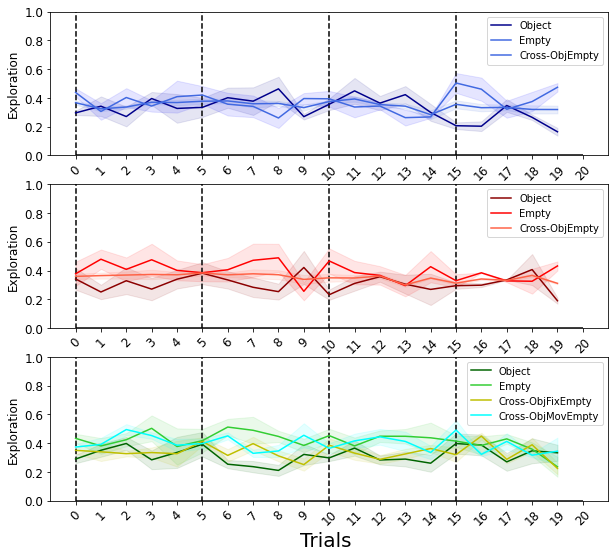

In [16]:
random_mean_occ = np.nanmean(DI_oo_random, axis = 0)
random_sem_occ =  np.nanstd(DI_oo_random,axis = 0)/np.sqrt(len(DI_oo_random))
random_mean_emp = np.nanmean(DI_ee_random, axis = 0)
random_sem_emp =  np.nanstd(DI_ee_random,axis = 0)/np.sqrt(len(DI_ee_random))
random_mean_cross = np.nanmean(DI_oe_random, axis = 0)
random_sem_cross =  np.nanstd(DI_oe_random,axis = 0)/np.sqrt(len(DI_oe_random))

stable_mean_occ = np.nanmean(DI_oo_stable, axis = 0)
stable_sem_occ =  np.nanstd(DI_oo_stable,axis = 0)/np.sqrt(len(DI_oo_stable))
stable_mean_emp = np.nanmean(DI_ee_stable, axis = 0)
stable_sem_emp =  np.nanstd(DI_ee_stable,axis = 0)/np.sqrt(len(DI_ee_stable))
stable_mean_cross = np.nanmean(DI_oe_stable, axis = 0)
stable_sem_cross =  np.nanstd(DI_oe_stable,axis = 0)/np.sqrt(len(DI_oe_stable))

overlapping_mean_occ = np.nanmean(DI_oo_overlapping , axis = 0)
overlapping_sem_occ =  np.nanstd(DI_oo_overlapping ,axis = 0)/np.sqrt(len(DI_oo_overlapping ))
overlapping_mean_emp = np.nanmean(DI_ee_overlapping, axis = 0)
overlapping_sem_emp =  np.nanstd(DI_ee_overlapping,axis = 0)/np.sqrt(len(DI_ee_overlapping))
overlapping_mean_cross_fix = np.nanmean(DI_oe_overlapping_fix, axis = 0)
overlapping_sem_cross_fix =  np.nanstd(DI_oe_overlapping_fix,axis = 0)/np.sqrt(len(DI_oe_overlapping_fix))
overlapping_mean_cross_mov = np.nanmean(DI_oe_overlapping_mov, axis = 0)
overlapping_sem_cross_mov =  np.nanstd(DI_oe_overlapping_mov,axis = 0)/np.sqrt(len(DI_oe_overlapping_mov))

figure, axes = plt.subplots(3,1)
 
titles = ['RANDOM','STABLE','OVERLAPPING']

time = np.arange(0,20)
axes[0].plot(time,random_mean_occ[time],'darkblue')
axes[1].plot(time,stable_mean_occ[time],'darkred')
axes[2].plot(time,overlapping_mean_occ[time],'darkgreen')
axes[0].fill_between(time,random_mean_occ[time]-random_sem_occ[time],random_mean_occ[time]+random_sem_occ[time],alpha = 0.1, edgecolor = 'darkblue', facecolor = 'darkblue')
axes[1].fill_between(time,stable_mean_occ[time]-stable_sem_occ[time],stable_mean_occ[time]+stable_sem_occ[time],alpha = 0.1, edgecolor = 'darkred', facecolor = 'darkred')
axes[2].fill_between(time,overlapping_mean_occ[time]-overlapping_sem_occ[time],overlapping_mean_occ[time]+overlapping_sem_occ[time],alpha = 0.1, edgecolor = 'darkgreen', facecolor = 'darkgreen')
        
axes[0].plot(time,random_mean_emp[time],'royalblue')
axes[1].plot(time,stable_mean_emp[time],'red')
axes[2].plot(time,overlapping_mean_emp[time],'limegreen')
axes[0].fill_between(time,random_mean_emp[time]-random_sem_emp[time],random_mean_emp[time]+random_sem_emp[time],alpha = 0.1, edgecolor = 'blue', facecolor = 'blue')
axes[1].fill_between(time,stable_mean_emp[time]-stable_sem_emp[time],stable_mean_emp[time]+stable_sem_emp[time],alpha = 0.1, edgecolor = 'red', facecolor = 'red')
axes[2].fill_between(time,overlapping_mean_emp[time]-overlapping_sem_emp[time],overlapping_mean_emp[time]+overlapping_sem_emp[time],alpha = 0.1, edgecolor = 'limegreen', facecolor = 'limegreen')
        

axes[0].plot(time,random_mean_cross[time],'royalblue')
axes[1].plot(time,stable_mean_cross[time],'tomato')
axes[2].plot(time,overlapping_mean_cross_fix[time],'y')
axes[2].plot(time,overlapping_mean_cross_mov[time],'cyan')
axes[0].fill_between(time,random_mean_cross[time]-random_sem_cross[time],random_mean_cross[time]+random_sem_cross[time],alpha = 0.1, edgecolor = 'royalblue', facecolor = 'royalblue')
axes[1].fill_between(time,stable_mean_cross[time]-stable_sem_cross[time],stable_mean_cross[time]+stable_sem_cross[time],alpha = 0.1, edgecolor = 'tomato', facecolor = 'tomato')
axes[2].fill_between(time,overlapping_mean_cross_fix[time]-overlapping_sem_cross_fix[time],overlapping_mean_cross_fix[time]+overlapping_sem_cross_fix[time],alpha = 0.1, edgecolor = 'y', facecolor = 'y')
axes[2].fill_between(time,overlapping_mean_cross_mov[time]-overlapping_sem_cross_mov[time],overlapping_mean_cross_mov[time]+overlapping_sem_cross_mov[time],alpha = 0.1, edgecolor = 'cyan', facecolor = 'cyan')

    
for j in range(3):
    axes[j].set_ylim([0,1])
    axes[j].set_ylabel('Exploration',fontsize = 12)
    axes[j].tick_params(axis='x', labelsize=12)
    axes[j].set_xticks(np.arange(0,21))

    axes[j].tick_params(axis='y', labelsize=12)  
    for tick in axes[j].get_xticklabels():
        tick.set_rotation(45)
    axes[j].hlines(0,0,20,color = 'k')  
    if j < 2:
        axes[j].legend(['Object','Empty','Cross-ObjEmpty'], fontsize = 10)
    #axes[j].set_title(titles[j],fontsize = 20)
    axes[j].vlines([0,5,10,15], -1, 3, colors='k', linestyles='dashed')

axes[2].set_xlabel('Trials ',fontsize = 20)
axes[2].legend(['Object','Empty','Cross-ObjFixEmpty','Cross-ObjMovEmpty'], fontsize = 10)

figure.set_size_inches([10,9])
figure.patch.set_facecolor('white')
figure.savefig(figure_path + 'CumExp_all.png')

In [17]:
###conditions
random_all = DI_oo_random
random_all = np.concatenate((random_all,DI_ee_random),axis = 0)
random_all = np.concatenate((random_all,DI_oe_random),axis = 0)
random_all = np.abs(random_all)

overlapping_all = DI_oo_overlapping
overlapping_all = np.concatenate((overlapping_all,DI_ee_overlapping),axis = 0)
overlapping_all = np.concatenate((overlapping_all,DI_oe_overlapping_fix),axis = 0)
overlapping_all = np.concatenate((overlapping_all,DI_oe_overlapping_mov),axis = 0)
overlapping_all = np.abs(overlapping_all)

stable_all = DI_oo_stable
stable_all = np.concatenate((stable_all,DI_ee_stable),axis = 0)
stable_all = np.concatenate((stable_all,DI_oe_stable),axis = 0)
stable_all = np.abs(stable_all)

###category
object_all = DI_oo_random
object_all = np.concatenate((object_all,DI_oo_overlapping),axis = 0)
object_all = np.concatenate((object_all,DI_oo_stable),axis = 0)
object_all = np.abs(object_all)

empty_all = DI_ee_random
empty_all = np.concatenate((empty_all,DI_ee_overlapping),axis = 0)
empty_all = np.concatenate((empty_all,DI_ee_stable),axis = 0)
empty_all = np.abs(empty_all)

cross_all = DI_oe_random
cross_all = np.concatenate((cross_all,DI_oe_overlapping_fix),axis = 0)
cross_all = np.concatenate((cross_all,DI_oe_overlapping_mov),axis = 0)
cross_all = np.concatenate((cross_all,DI_oe_stable),axis = 0)
cross_all = np.abs(cross_all)

In [18]:
len(DI_oo_stable)

4

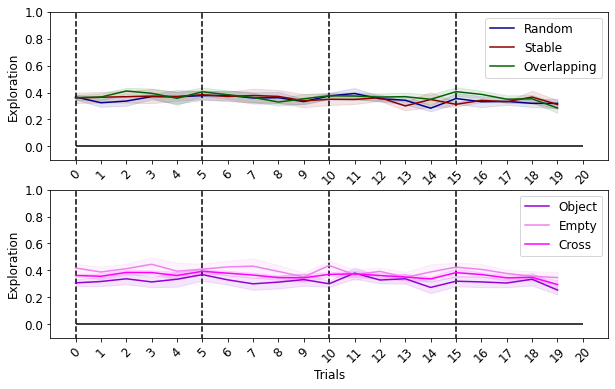

In [19]:
# data_path = os.environ['PROJECT_DIR'] +'neural_analysis/figures/mean_representational_distance/lda_3/'
# file_name = 'di_random.npy'
# np.save(data_path + file_name, random_all)
# file_name = 'di_stable.npy'
# np.save(data_path + file_name, stable_all)
# file_name = 'di_overlapping.npy'
# np.save(data_path + file_name, overlapping_all)    

# file_name = 'di_object.npy'
# np.save(data_path + file_name, object_all)
# file_name = 'di_empty.npy'
# np.save(data_path + file_name, stable_all)
# file_name = 'di_cross.npy'
# np.save(data_path + file_name, cross_all)    



random_mean = np.nanmean(random_all, axis = 0)
random_sem =  np.nanstd(random_all,axis = 0)/np.sqrt(len(random_all))
stable_mean = np.nanmean(stable_all, axis = 0)
stable_sem =  np.nanstd(stable_all,axis = 0)/np.sqrt(len(stable_all))
overlapping_mean= np.nanmean(overlapping_all, axis = 0)
overlapping_sem =  np.nanstd(overlapping_all,axis = 0)/np.sqrt(len(overlapping_all))

occ_mean = np.nanmean(object_all, axis = 0)
occ_sem =  np.nanstd(object_all,axis = 0)/np.sqrt(len(object_all))
empty_mean = np.nanmean(empty_all, axis = 0)
empty_sem =  np.nanstd(empty_all,axis = 0)/np.sqrt(len(empty_all))
cross_mean= np.nanmean(cross_all, axis = 0)
cross_sem =  np.nanstd(cross_all,axis = 0)/np.sqrt(len(overlapping_all))

figure, axes = plt.subplots(2,1)
 
titles = ['RANDOM','STABLE','OVERLAPPING']

time = np.arange(0,20)
axes[0].plot(time,random_mean[time],'darkblue')
axes[0].plot(time,stable_mean[time],'darkred')
axes[0].plot(time,overlapping_mean[time],'darkgreen')
axes[0].fill_between(time,random_mean[time]-random_sem[time],random_mean[time]+random_sem[time],alpha = 0.1, edgecolor = 'darkblue', facecolor = 'darkblue')
axes[0].fill_between(time,stable_mean[time]-stable_sem[time],stable_mean[time]+stable_sem[time],alpha = 0.1, edgecolor = 'darkred', facecolor = 'darkred')
axes[0].fill_between(time,overlapping_mean[time]-overlapping_sem[time],overlapping_mean[time]+overlapping_sem[time],alpha = 0.1, edgecolor = 'darkgreen', facecolor = 'darkgreen')
    
axes[1].plot(time,occ_mean[time],'darkviolet')
axes[1].plot(time,empty_mean[time],'violet')
axes[1].plot(time,cross_mean[time],'magenta')
axes[1].fill_between(time,occ_mean[time]-occ_sem[time],occ_mean[time]+occ_sem[time],alpha = 0.1, edgecolor = 'darkviolet', facecolor = 'darkviolet')
axes[1].fill_between(time,empty_mean[time]-empty_sem[time],empty_mean[time]+empty_sem[time],alpha = 0.1, edgecolor = 'violet', facecolor = 'violet')
axes[1].fill_between(time,cross_mean[time]-cross_sem[time],cross_mean[time]+cross_sem[time],alpha = 0.1, edgecolor = 'magenta', facecolor = 'magenta')
    

for j in range(2):
    axes[j].set_ylim([-0.1,1])
    axes[j].set_ylabel('Exploration',fontsize = 12)
    axes[j].tick_params(axis='x', labelsize=12)
    axes[j].set_xticks(np.arange(0,21))

    axes[j].tick_params(axis='y', labelsize=12)  
    for tick in axes[j].get_xticklabels():
        tick.set_rotation(45)
    axes[j].hlines(0,0,20,color = 'k')  
    axes[j].vlines([0,5,10,15], -1, 3, colors='k', linestyles='dashed')
    
axes[0].legend(['Random','Stable','Overlapping'], fontsize = 12)
axes[1].legend(['Object','Empty','Cross'], fontsize = 12)

axes[1].set_xlabel('Trials', fontsize = 12)

figure.set_size_inches([10,6])
figure.patch.set_facecolor('white')
figure.savefig(figure_path + 'CumEXP_evolution_category_conditions.png')

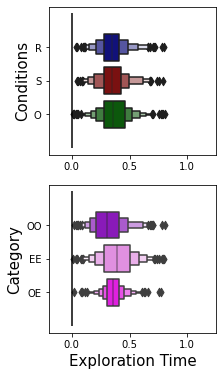

In [22]:
figure = plt.figure()
gs = plt.GridSpec(2,1)

label_conditions = ['R','S','O']
label_category = ['OO','EE','OE']
   
plot_list = [[random_all[~np.isnan(random_all)]],[stable_all[~np.isnan(stable_all)]],[overlapping_all[~np.isnan(overlapping_all)]]]
    
ax1 = figure.add_subplot(gs[0,0])
ax1.set_ylabel('Conditions', fontsize = 15)
#ax1.set_xlabel('Discrimination Index',fontsize = 15)
ax1 = sns.boxenplot(data = plot_list, orient = 'h', palette = ['darkblue','darkred','darkgreen'])
ax1.set_yticklabels(label_conditions)
ax1.set_xlim([-0.2,1.25])
ax1.vlines(0,-1,3, color = 'k')
for tick in ax1.get_xticklabels():
    tick.set_rotation(0)
        
plot_list = [[object_all],[empty_all],[cross_all]]
                     
ax1 = figure.add_subplot(gs[1,0])
ax1.set_ylabel('Category', fontsize = 15)
ax1.set_xlabel('Exploration Time',fontsize = 15)
ax1 = sns.boxenplot(data = plot_list, orient = 'h',palette = ['darkviolet','violet','magenta'])
ax1.set_yticklabels(label_category)
ax1.set_xlim([-0.2,1.25])
ax1.vlines(0,-1,3, color = 'k')
for tick in ax1.get_xticklabels():
    tick.set_rotation(0)
        
        
figure.set_size_inches([3,6])
figure.patch.set_facecolor('white')

figure.savefig(figure_path + 'Exp_conditions_category_boxen.png')

In [23]:
def reshape_evolution(evolution):
    
    reshape_evolution_trial = np.zeros((len(evolution)*4,5))
    reshape_evolution_day = np.zeros((4,5*len(evolution)))

    for i in range(len(evolution)):
        r_evolution = evolution[i].reshape(4,5)
        reshape_evolution_trial[i*4:(i+1)*4,:] = r_evolution
        r_evolution = evolution[i].reshape(4,5)
        reshape_evolution_day[:,i*5:(i+1)*5] = r_evolution
     
    return [reshape_evolution_trial, reshape_evolution_day]

def compute_mean_evolution(evolution):
    
    [reshape_evo_trial, reshape_evo_day] = reshape_evolution(evolution)
    mean_trial = np.nanmean(reshape_evo_trial,axis =0)
    std_trial = np.nanmean(reshape_evo_trial,axis =0)/np.sqrt(reshape_evo_trial.shape[0])
    
    mean_day = np.nanmean(reshape_evo_day,axis =1)
    std_day = np.nanmean(reshape_evo_day,axis =1)/np.sqrt(reshape_evo_day.shape[1])

    return mean_trial, std_trial, mean_day, std_day

In [24]:
[r_occ1, r_occ1_sem, r_occ2, r_occ2_sem] = compute_mean_evolution(DI_oo_random)
[r_emp1, r_emp1_sem, r_emp2, r_emp2_sem] = compute_mean_evolution(DI_ee_random)
[r_cross1,r_cross1_sem,r_cross2,r_cross2_sem] = compute_mean_evolution(DI_oe_random)

[s_occ1, s_occ1_sem, s_occ2, s_occ2_sem] = compute_mean_evolution(DI_oo_stable)
[s_emp1, s_emp1_sem, s_emp2, s_emp2_sem] = compute_mean_evolution(DI_ee_stable)
[s_cross1,s_cross1_sem,s_cross2,s_cross2_sem] = compute_mean_evolution(DI_oe_stable)

[o_occ1, o_occ1_sem, o_occ2, o_occ2_sem] = compute_mean_evolution(DI_oo_overlapping)
[o_emp1, o_emp1_sem, o_emp2, o_emp2_sem]= compute_mean_evolution(DI_ee_overlapping)
[o_cross_fix1,o_cross_fix1_sem,o_cross_fix2,o_cross_fix2_sem] = compute_mean_evolution(DI_oe_overlapping_fix)
[o_cross_mov1,o_cross_mov1_sem,o_cross_mov2,o_cross_mov2_sem] = compute_mean_evolution(DI_oe_overlapping_mov)

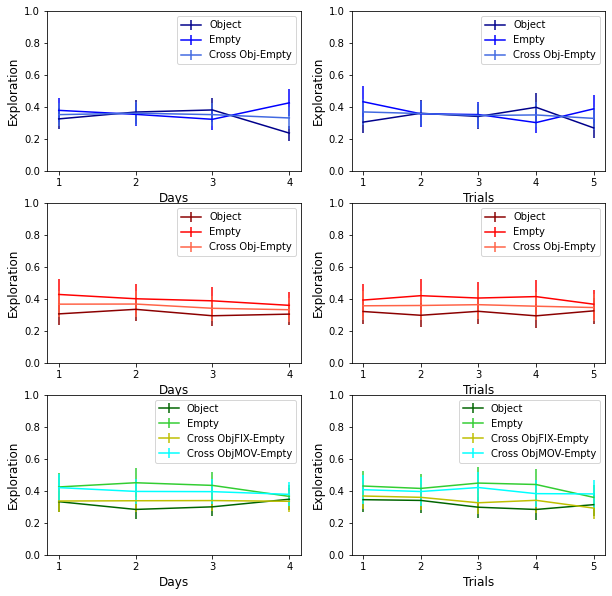

In [25]:
label = ['Cumulative Sum Addition']
titles = ['RANDOM','STABLE','OVERLAPPING']
figure, axes = plt.subplots(3,2)
trial_id = np.arange(1,5)
    
axes[0,0].errorbar(trial_id,r_occ2,r_occ2_sem, color = 'darkblue')
axes[0,0].errorbar(trial_id,r_emp2,r_emp2_sem, color = 'blue')
axes[0,0].errorbar(trial_id,r_cross2,r_cross2_sem, color = 'royalblue')
axes[0,0].legend(['Object','Empty','Cross Obj-Empty'])

axes[1,0].errorbar(trial_id,s_occ2,s_occ2_sem, color = 'darkred')
axes[1,0].errorbar(trial_id,s_emp2,s_emp2_sem, color = 'red')
axes[1,0].errorbar(trial_id,s_cross2,s_cross2_sem, color = 'tomato')
axes[1,0].legend(['Object','Empty','Cross Obj-Empty'])

axes[2,0].errorbar(trial_id,o_occ2,o_occ2_sem, color = 'darkgreen')
axes[2,0].errorbar(trial_id,o_emp2,o_emp2_sem, color = 'limegreen')
axes[2,0].errorbar(trial_id,o_cross_fix2,o_cross_fix2_sem, color = 'y')
axes[2,0].errorbar(trial_id,o_cross_mov2,o_cross_mov2_sem, color = 'cyan')
axes[2,0].legend(['Object','Empty','Cross ObjFIX-Empty','Cross ObjMOV-Empty'])

trial_id = np.arange(1,6)

axes[0,1].errorbar(trial_id,r_occ1,r_occ1_sem, color = 'darkblue')
axes[0,1].errorbar(trial_id,r_emp1,r_emp1_sem, color = 'blue')
axes[0,1].errorbar(trial_id,r_cross1,r_cross1_sem, color = 'royalblue')
axes[0,1].legend(['Object','Empty','Cross Obj-Empty'])

axes[1,1].errorbar(trial_id,s_occ1,s_occ1_sem, color = 'darkred')
axes[1,1].errorbar(trial_id,s_emp1,s_emp1_sem, color = 'red')
axes[1,1].errorbar(trial_id,s_cross1,s_cross1_sem, color = 'tomato')
axes[1,1].legend(['Object','Empty','Cross Obj-Empty'])

axes[2,1].errorbar(trial_id,o_occ1,o_occ1_sem, color = 'darkgreen')
axes[2,1].errorbar(trial_id,o_emp1,o_emp1_sem, color = 'limegreen')
axes[2,1].errorbar(trial_id,o_cross_fix1,o_cross_fix1_sem, color = 'y')
axes[2,1].errorbar(trial_id,o_cross_mov1,o_cross_mov1_sem, color = 'cyan')
axes[2,1].legend(['Object','Empty','Cross ObjFIX-Empty','Cross ObjMOV-Empty'])


trials_comparison_pos = [1,2,3,4]
for j in range(3):
    axes[j,0].set_xticks(trials_comparison_pos)
    axes[j,0].set_ylim([0,1])
    axes[j,0].set_xlabel('Days', fontsize = 12)
    axes[j,0].set_ylabel('DiscriminationIndex', fontsize = 12)
    axes[j,0].set_ylabel('Exploration', fontsize = 12)

    #axes[j,0].set_title(titles[j],fontsize = 15)
    
trials_comparison_pos = [1,2,3,4,5]
for j in range(3):
    axes[j,1].set_xticks(trials_comparison_pos)
    axes[j,1].set_ylim([0,1])
    axes[j,1].set_xlabel('Trials', fontsize = 12)
    #axes[j,1].set_ylabel('DiscriminationIndex', fontsize = 12)
    axes[j,1].set_ylabel('Exploration', fontsize = 12)

    #axes[j,1].set_title(titles[j],fontsize = 15)
             
figure.set_size_inches([10,10])
figure.patch.set_facecolor('white')

figure.savefig(figure_path + 'Exp_all_trials_and_days.png')

In [27]:
[r_1, r_1_sem, r_2, r_2_sem] = compute_mean_evolution(random_all)
[s_1, s_1_sem, s_2, s_2_sem] = compute_mean_evolution(stable_all)
[o_1, o_1_sem, o_2, o_2_sem] = compute_mean_evolution(overlapping_all)


[oo_1, oo_1_sem, oo_2, oo_2_sem] = compute_mean_evolution(object_all)
[ee_1, ee_1_sem, ee_2, ee_2_sem] = compute_mean_evolution(empty_all)
[oe_1, oe_1_sem, oe_2, oe_2_sem] = compute_mean_evolution(cross_all)

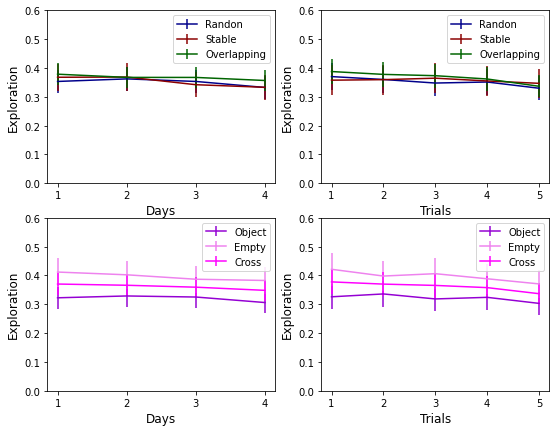

In [28]:
label = ['Cumulative Sum Addition']
titles = ['RANDOM','STABLE','OVERLAPPING']
figure, axes = plt.subplots(2,2)

trial_id = np.arange(1,5)
axes[0,0].errorbar(trial_id,r_2,r_2_sem, color = 'darkblue')
axes[0,0].errorbar(trial_id,s_2,s_2_sem, color = 'darkred')
axes[0,0].errorbar(trial_id,o_2,o_2_sem, color = 'darkgreen')
axes[0,0].legend(['Randon','Stable','Overlapping'])

axes[1,0].errorbar(trial_id,oo_2,oo_2_sem, color = 'darkviolet')
axes[1,0].errorbar(trial_id,ee_2,ee_2_sem, color = 'violet')
axes[1,0].errorbar(trial_id,oe_2,oe_2_sem, color = 'magenta')
axes[1,0].legend(['Object','Empty','Cross'])

trial_id = np.arange(1,6)

axes[0,1].errorbar(trial_id,r_1,r_1_sem, color = 'darkblue')
axes[0,1].errorbar(trial_id,s_1,s_1_sem, color = 'darkred')
axes[0,1].errorbar(trial_id,o_1,o_1_sem, color = 'darkgreen')
axes[0,1].legend(['Randon','Stable','Overlapping'])

axes[1,1].errorbar(trial_id,oo_1,oo_1_sem, color = 'darkviolet')
axes[1,1].errorbar(trial_id,ee_1,ee_1_sem, color = 'violet')
axes[1,1].errorbar(trial_id,oe_1,oe_1_sem, color = 'magenta')
axes[1,1].legend(['Object','Empty','Cross'])

trials_comparison_pos = [1,2,3,4]
for j in range(2):
    axes[j,0].set_xticks(trials_comparison_pos)
    axes[j,0].set_ylim([0,0.6])
    axes[j,0].set_xlabel('Days', fontsize = 12)
    axes[j,0].set_ylabel('Exploration', fontsize = 12)
    
    #axes[j,0].set_ylabel('Discriminability', fontsize = 12)
    #axes[j,0].set_title(titles[j],fontsize = 15)
    
trials_comparison_pos = [1,2,3,4,5]
for j in range(2):
    axes[j,1].set_xticks(trials_comparison_pos)
    axes[j,1].set_ylim([0,0.6])
    axes[j,1].set_xlabel('Trials', fontsize = 12)
    axes[j,1].set_ylabel('Discriminability', fontsize = 12)
    axes[j,1].set_ylabel('Exploration', fontsize = 12)    
    #axes[j,1].set_title(titles[j],fontsize = 15)
             
figure.set_size_inches([9,7])
figure.patch.set_facecolor('white')

figure.savefig(figure_path + 'Exp_all_trials_and_days.png')

array([[nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan]])